# Explore here

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf





In [3]:
!pip install numpy==1.23.5 scipy cython
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import warnings

In [5]:
warnings.filterwarnings("ignore")

In [6]:
df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [7]:
df["date"] = pd.to_datetime(df["date"])
df["date"] = df["date"].dt.normalize()
df.set_index("date", inplace=True)

ts= df["sales"]
ts

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 366, dtype: float64

In [8]:
tensor = ts.index.to_series().diff().mode()[0]
print(f"El tensor de la serie temporal es: {tensor}")


El tensor de la serie temporal es: 1 days 00:00:00


El tensor de la serie temporal es de 1 día, lo que significa que los datos están registrados diariamente.

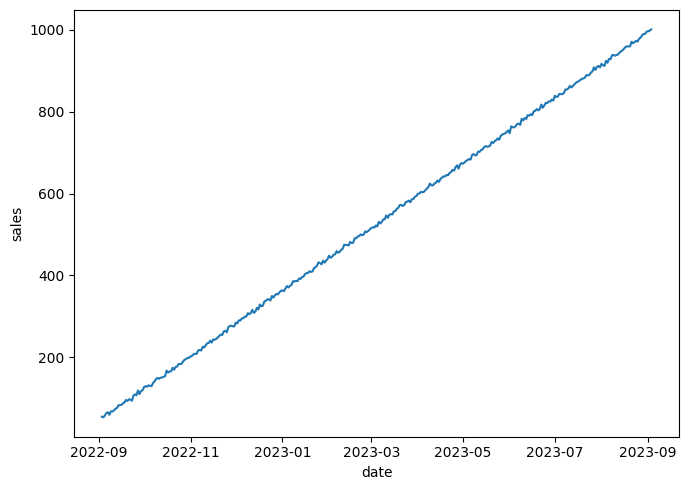

In [9]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (7, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 12)
decomposition

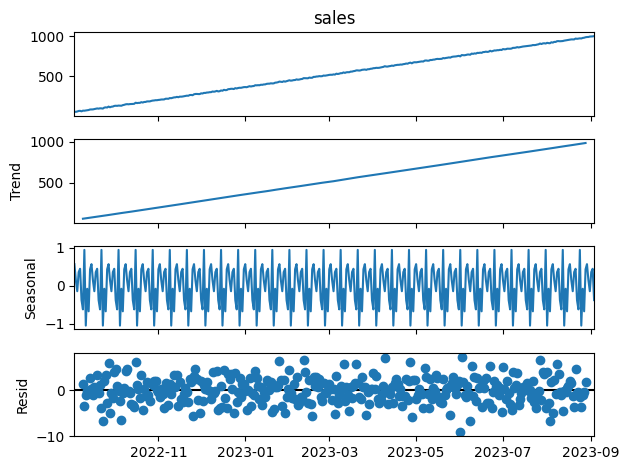

In [11]:
import matplotlib.pyplot as plt

decomposition.plot()
plt.tight_layout()
plt.show()


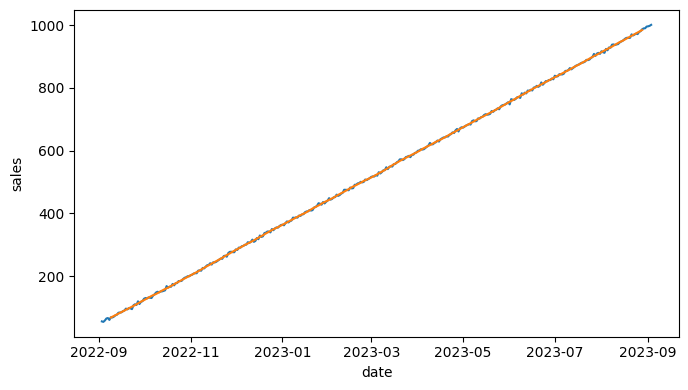

In [12]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (7, 4))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Hay una tendencia positiva en las ventas

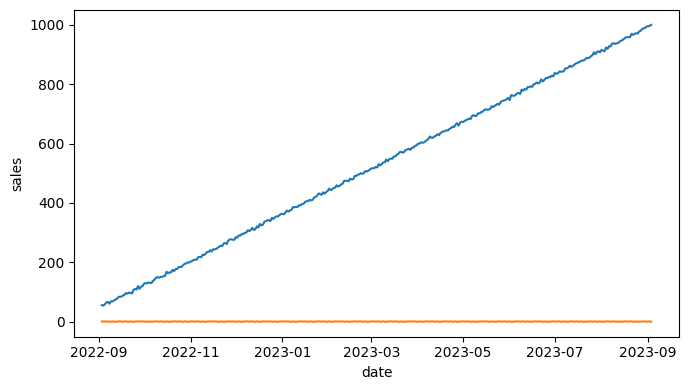

In [13]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (7, 4))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

No se observa estacionalidad

In [14]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Confirmado, la serie no es estacionaria, asi que hay que diferenciarla

In [15]:
ts_diff = ts.diff().dropna()

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

El p-value es muy pequeño, por debajo de 0.05 por lo tanto ya es estacionaria y d=1

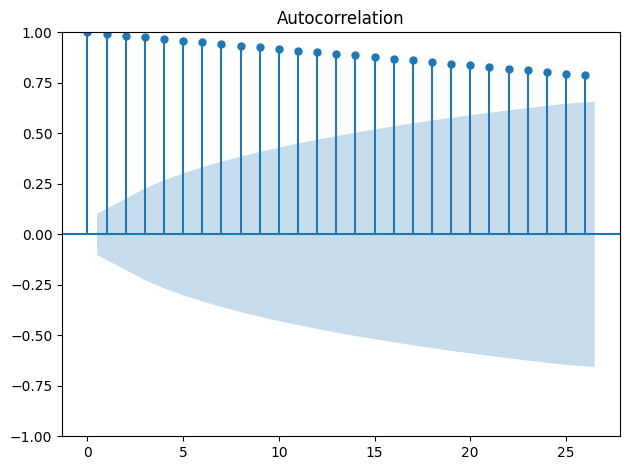

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación con la copia retrasada que disminuye con el tiempo, a priori todas las barras (hasta el lag 25) están fuera del intervalo de confianza, y disminuyen lentamente, es más una decadencia lenta que cambio brusco, por lo que se podría probar con un q=0.

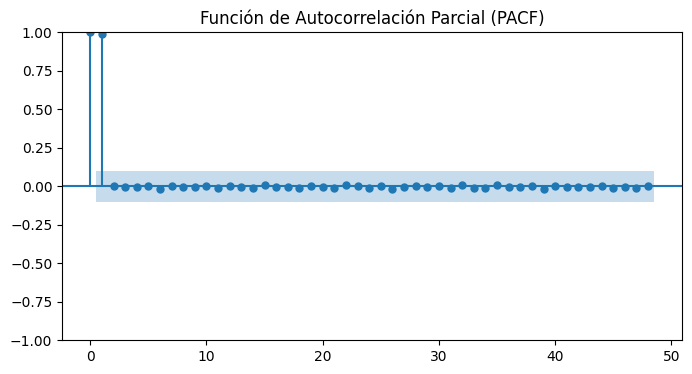

In [20]:
# Graficar PACF
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(8, 4))
plot_pacf(ts, lags=48, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

A partir del lag 2, todas las barras están dentro del intervalo de confianza, lo que sugiere que no hay autocorrelación parcial significativa más allá del primer lag. AR(1) podría ser una buena elección. (p=1)

In [ ]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

se sigue apreciando la estacionalidad, vamos se confirma.

In [ ]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.106, Time=1.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=1.06 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.40 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.18 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.32 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.436, Time=1.29 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.03 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=1845.691, Time=1.60 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.27 sec
 ARIMA(1,0,1)(1,0,0)[12]

como ya se ha diferenciado, ahora no necesita diferenciarse de nuevo y por tanto considera d=0

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Mon, 05 May 2025   AIC                           1839.553
Time:                        19:24:28   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Para una serie donde los valores están cerca de 1000 , la varianza de los residuos (=8.7903)  implica residuos pequeños en proporción a las ventas.Es decir, el modelo no está cometiendo errores grandes y por tanto residuos bajos.

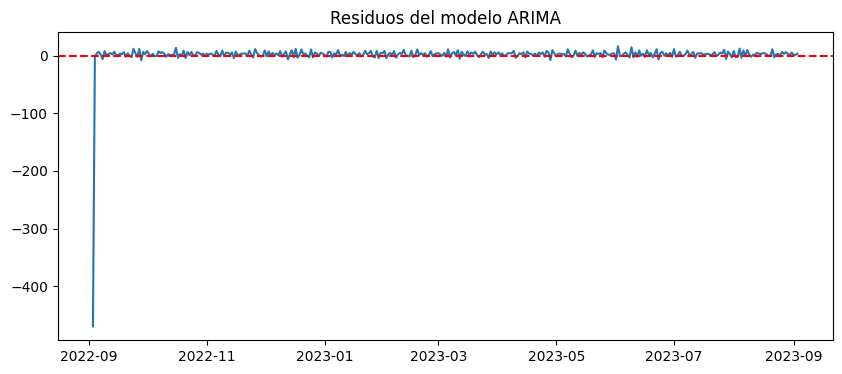

In [31]:
residuos = resultado_arima.resid
plt.figure(figsize=(10,4))
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


In [21]:
p = 1
d = 0
q = 1

modelo_arima = ARIMA(ts, order=(p,d,q))

resultado_arima = modelo_arima.fit()

In [48]:
forecast = resultado_arima.forecast(steps=3)  # predicción para los próximos 3 meses

last_value = ts.iloc[-1]
forecast_original_scale = forecast.cumsum() + last_value

# Asignar fechas a las predicciones
forecast_original_scale.index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')

# Mostrar o graficar
print(forecast_original_scale)


2023-11-01    2000.696161
2023-12-01    3000.886921
2024-01-01    4001.055067
Freq: MS, Name: predicted_mean, dtype: float64


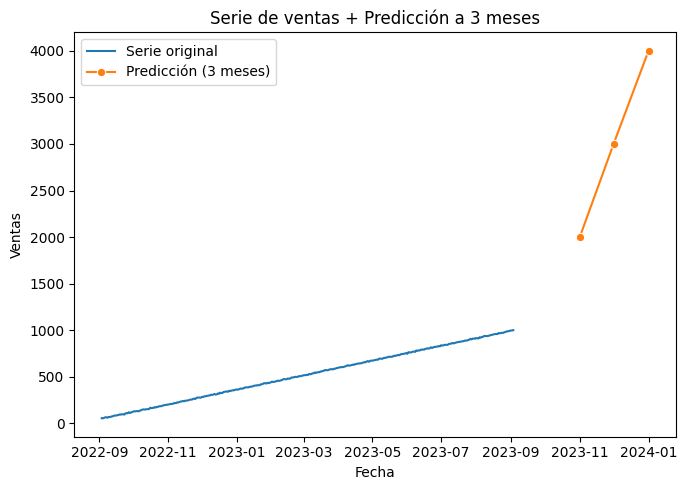

In [52]:
plt.figure(figsize=(7, 5))

# Graficar la serie original
sns.lineplot(data=ts, label="Serie original")

# Graficar las predicciones futuras
sns.lineplot(data=forecast_original_scale, label="Predicción (3 meses)", marker="o")

# Mostrar leyenda y gráfico
plt.title("Serie de ventas + Predicción a 3 meses")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()

Aparentemente hay una previsión de aumento de ventas muy fuerte, pasando de 2000 a 4000 a finales del trimestre

Para hacer una predicción sobre un conunto test usando forecast(), tendría que haber hecho una división en test y train antes, cosa que no he hecho, siguieno las guías de la plataforma. Como estoy usando los mismo datos, tiene más lógica usar predict(). Puedo volver a cargar los datos, para hacer el split y usar esos datos para predecir el test, que obviamnete no es lo ideal, porque ya ha usado esos datos en el modelo.

In [53]:
import pickle
from datetime import datetime

# Ruta y nombre del modelo
ruta_modelo = "/workspaces/Finarosalina_Serie-Temporal_Arima_ML/models/arima_111_manual_diff1_sales.pkl"
ruta_metadata = "/workspaces/Finarosalina_Serie-Temporal_Arima_ML/models/arima_111_manual_diff1_sales_metadata.txt"

# Guardar el modelo ARIMA entrenado
with open(ruta_modelo, 'wb') as f:
    pickle.dump(resultado_arima, f)

# Guardar metadata del modelo
with open(ruta_metadata, 'w') as f:
    f.write("MODELO ARIMA (guardado automáticamente)\n")
    f.write(f"Fecha de guardado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("==========================================\n")
    f.write("Modelo: ARIMA(1,1,1)\n")
    f.write("Diferenciación: 1 (aplicada manualmente con .diff())\n")
    f.write("Datos usados: Serie temporal 'sales' del dataset original\n")
    f.write(f"Última fecha en los datos: {ts.index[-1]}\n")
    f.write(f"Último valor antes de forecast: {ts.iloc[-1]}\n")
    f.write("Resumen del modelo:\n")
    f.write(str(resultado_arima.summary()))


In [57]:
import nbformat
from nbconvert import PythonExporter

with open("/workspaces/Finarosalina_Serie-Temporal_Arima_ML/src/explore.ipynb", "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

exporter = PythonExporter()
codigo_python, _ = exporter.from_notebook_node(notebook)

with open("/workspaces/Finarosalina_Serie-Temporal_Arima_ML/src/app.py", "w", encoding="utf-8") as f:
    f.write(codigo_python)
